In [34]:
# data manipulations
import numpy as np
import pandas as pd
# progress bar
from tqdm.notebook import tqdm_notebook
# audio analysis
import librosa
# noise reducer
import noisereduce as nr
# standardization
from sklearn.preprocessing import StandardScaler
# serialization of objects
import pickle
# working with directory
import pathlib

In [2]:
# printing results and listening
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

def wave_and_audio(sample, sr):
    # plot the signal
    plt.figure(figsize=(10, 4))
    librosa.display.waveplot(sample, sr=sr)
    plt.title('Waveplot of audio sample')
    plt.show()
    # reproduce the sample
    ipd.display(ipd.Audio(sample, rate=sr))

In [3]:
metadata = pd.read_csv("to_load.csv")
metadata.head()

,path,label,samplingrate,nframes,ms
0,./Labelled/Bleatings/evt_000_000_000681_210415...,Bleatings,16000,156016,9751.0
1,./Labelled/Bleatings/evt_000_000_000682_210415...,Bleatings,16000,99040,6190.0
2,./Labelled/Bleatings/evt_000_000_000683_210415...,Bleatings,16000,97152,6072.0
3,./Labelled/Bleatings/evt_000_000_000684_210415...,Bleatings,16000,97696,6106.0
4,./Labelled/Bleatings/evt_000_000_002434_210416...,Bleatings,16000,164224,10264.0


In [4]:
sr = metadata["samplingrate"][0]
sr

16000

In [5]:
paths = metadata["path"]
samples = []
for path in tqdm_notebook(paths):
    sample, sampling_rate = librosa.load(path, sr=None, mono=True)
    samples.append(sample)
samples[:5]

  0%|          | 0/827 [00:00<?, ?it/s]

[array([ 0.01379395,  0.00057983,  0.01922607, ..., -0.01580811,
        -0.01345825, -0.01861572], dtype=float32),
 array([-0.01376343, -0.00183105,  0.00115967, ...,  0.02661133,
         0.02331543,  0.01779175], dtype=float32),
 array([-2.3986816e-02, -9.6130371e-03, -1.3641357e-02, ...,
        -1.0070801e-02,  6.1035156e-05,  4.5776367e-03], dtype=float32),
 array([-0.01174927, -0.00735474, -0.00198364, ..., -0.00079346,
         0.00054932, -0.00073242], dtype=float32),
 array([ 0.05810547,  0.0345459 ,  0.0211792 , ..., -0.07623291,
         0.03268433,  0.13360596], dtype=float32)]

# Preprocessing

## Segment the long sample

Let's break all the sample above of 3 seconds in subsample with a window 3 of seconds and hop size 1.5 seconds 

In [8]:
max_len = 3
condition = metadata["ms"] > max_len*1000
long = metadata[condition]
len(long)

827

All the samples must be splitted

In [9]:
def split_in_equal(sample, sr, maxd):
    buffer = maxd * sr
    step = maxd/2
    samples_total = len(sample)
    samples_wrote = 0
    next_buffer = 0


    splitted_sample = []

    while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - next_buffer):
            buffer = samples_total - next_buffer

        end = next_buffer + buffer
        block = sample[next_buffer : end]
        splitted_sample.append(block)
        
        next_buffer = next_buffer + int(step * sr)
        
        buffer = maxd*sr
        samples_wrote = end
    return splitted_sample

In [10]:
split_samples = []
split_metadata = []
for c, sample in enumerate(tqdm_notebook(samples)):
    if metadata.iloc[c]["ms"] > max_len*1000:
        splitted_sample = split_in_equal(sample, sr, max_len)
        split_samples += splitted_sample
        new_metadata = [[metadata.iloc[c]["path"],
                         i,
                         metadata.iloc[c]["label"],
                         sr,
                         len(s),
                         1000*len(s)/sr]
                         for i, s in enumerate(splitted_sample)]
        split_metadata += new_metadata

split_metadata = pd.DataFrame(split_metadata, columns=["path", "segment", "label", "samplingrate", "nframes", "ms"])
split_metadata

  0%|          | 0/827 [00:00<?, ?it/s]

,path,segment,label,samplingrate,nframes,ms
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,48000,3000.0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,48000,3000.0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,48000,3000.0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,48000,3000.0
4,./Labelled/Bleatings/evt_000_000_000681_210415...,4,Bleatings,16000,48000,3000.0
...,...,...,...,...,...,...
7015,./Labelled/Others/evt_003_003_069820_210609_06...,3,Others,16000,48000,3000.0
7016,./Labelled/Others/evt_003_003_069820_210609_06...,4,Others,16000,48000,3000.0
7017,./Labelled/Others/evt_003_003_069820_210609_06...,5,Others,16000,48000,3000.0
7018,./Labelled/Others/evt_003_003_069820_210609_06...,6,Others,16000,48000,3000.0


We obtained a total of 7020 samples from the original 827. Let's have a look at the ditrbituion of the class

In [11]:
count_label = split_metadata['label'].value_counts().to_frame()
count_label

,label
Bleatings,3066
Others,2730
ContactCalls,1224


We still need to increase the samples for contact calls.

## Data augmentation

## Denoising and trimming

Let's remove the noise from the samples and then trim the silent part at the beggining and ending of the samples.

In [12]:
denoise_trim_samples = []

for count, sample in enumerate(tqdm_notebook(split_samples)):
    if split_metadata.iloc[count]["label"] != "Others":
        sample = nr.reduce_noise(y=sample, sr=sr, use_tqdm=False)
    sample = librosa.effects.trim(sample, top_db=15, frame_length=512, hop_length=64)[0]
    denoise_trim_samples.append(sample)
denoise_trim_samples[:5]

  0%|          | 0/7020 [00:00<?, ?it/s]

[array([-0.02437842, -0.02365888, -0.00902225, ..., -0.00756735,
        -0.00464633, -0.0001669 ], dtype=float32),
 array([ 0.01265561,  0.00711744, -0.00751382, ...,  0.0012379 ,
         0.00226272,  0.00411485], dtype=float32),
 array([ 0.0124789 ,  0.01066994,  0.0083406 , ..., -0.0032531 ,
         0.0044106 ,  0.00692406], dtype=float32),
 array([-0.00345186,  0.0035702 ,  0.01045445, ..., -0.0037035 ,
         0.00380693,  0.00417307], dtype=float32),
 array([-1.03670144e-02, -7.80101586e-03, -2.67368346e-03, ...,
         7.08722582e-05, -1.04012266e-04, -2.75029871e-03], dtype=float32)]

In [13]:
metadata_clean = []
for sample in tqdm_notebook(denoise_trim_samples):
    nframe = len(sample)
    length = 1000*nframe/sr
    metadata_clean.append([nframe, length])

split_metadata_trim = pd.concat([split_metadata, pd.DataFrame(metadata_clean, columns = ["nframes_trim", "ms_trim"])], axis=1)
split_metadata_trim.head()

  0%|          | 0/7020 [00:00<?, ?it/s]

,path,segment,label,samplingrate,nframes,ms,nframes_trim,ms_trim
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,48000,3000.0,30720,1920.0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,48000,3000.0,40704,2544.0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,48000,3000.0,34880,2180.0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,48000,3000.0,20672,1292.0
4,./Labelled/Bleatings/evt_000_000_000681_210415...,4,Bleatings,16000,48000,3000.0,47808,2988.0


count    7020.000000
mean     2287.241311
std       840.152177
min        76.000000
25%      1728.000000
50%      2670.000000
75%      3000.000000
max      3000.000000
Name: ms_trim, dtype: float64

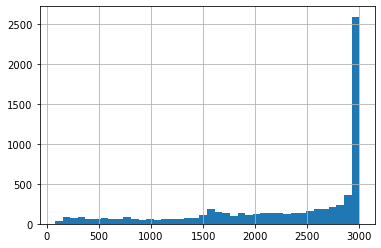

In [14]:
durations = split_metadata_trim['ms_trim']
durations.hist(bins=40)
durations.describe()

# Remove short samples

In [15]:
condition = split_metadata_trim["ms_trim"] > 500
split_metadata_trim = split_metadata_trim[condition]

condition.value_counts()

True     6639
False     381
Name: ms_trim, dtype: int64

In [16]:
processed_samples = [sample for count, sample in enumerate(denoise_trim_samples) if condition[count]==True]
len(processed_samples)

6639

In [17]:
split_metadata_trim

,path,segment,label,samplingrate,nframes,ms,nframes_trim,ms_trim
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,48000,3000.0,30720,1920.0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,48000,3000.0,40704,2544.0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,48000,3000.0,34880,2180.0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,48000,3000.0,20672,1292.0
4,./Labelled/Bleatings/evt_000_000_000681_210415...,4,Bleatings,16000,48000,3000.0,47808,2988.0
...,...,...,...,...,...,...,...,...
7015,./Labelled/Others/evt_003_003_069820_210609_06...,3,Others,16000,48000,3000.0,48000,3000.0
7016,./Labelled/Others/evt_003_003_069820_210609_06...,4,Others,16000,48000,3000.0,48000,3000.0
7017,./Labelled/Others/evt_003_003_069820_210609_06...,5,Others,16000,48000,3000.0,48000,3000.0
7018,./Labelled/Others/evt_003_003_069820_210609_06...,6,Others,16000,48000,3000.0,48000,3000.0


## Pad the short samples

Finally we can pad all the samples to the same lenght.<br>The max duration is 3000ms, which is 3 seconds. Let's pad all the shorter samples to this lenght by centering the sample in the middle of signal.

In [23]:
def zero_pad_data(sample, sr, length):
    """
    sample: audio sample
    sr: sample rate
    lenght: length to reach
    """
    # find lenght according to sr
    length = sr*length
    
    signal_padded = np.zeros(length)
    
    sample_len = len(sample)
    start = int(length/2) - int(sample_len/2)
    signal_padded[start: start+sample_len] = sample
    return signal_padded

processed_samples = [zero_pad_data(sample, sr, 3) for sample in processed_samples]

In [27]:
processed_metadata = split_metadata_trim[["path", "segment", "label", "samplingrate"]]

processed_metadata["ms"] = [1000*len(sample)/sr for sample in processed_samples]
#length_info = [1000*len(sample)/sr for sample in processed_samples]

#processed_metadata = pd.concat([processed_metadata, pd.DataFrame(length_info, columns = ["ms"])], axis=1, ignore_index=True)
processed_metadata['ms'].describe()

C:\Users\NICOLA~1\AppData\Local\Temp/ipykernel_6184/2019792334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_metadata["ms"] = [1000*len(sample)/sr for sample in processed_samples]


count    6639.0
mean     3000.0
std         0.0
min      3000.0
25%      3000.0
50%      3000.0
75%      3000.0
max      3000.0
Name: ms, dtype: float64

In [28]:
processed_metadata.to_csv("processed_metadata.csv", index=False)
processed_metadata.head()

,path,segment,label,samplingrate,ms
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,3000.0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,3000.0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,3000.0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,3000.0
4,./Labelled/Bleatings/evt_000_000_000681_210415...,4,Bleatings,16000,3000.0


# Log Mel-spectograms

We can compute the log mel-spectrogram of each sample, with 128 mel bands

In [35]:
logmelspectrograms = []
for sample in tqdm_notebook(processed_samples):
    S = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    logmelspectrograms.append(S_dB)

  0%|          | 0/6639 [00:00<?, ?it/s]

In [36]:
a, b, c = np.shape(logmelspectrograms)
print(f'A total of {a} samples, with {b} mel bands and {c} samples')

A total of 6639 samples, with 128 mel bands and 94 samples


Save the result for further processing

In [131]:
import pickle
pickle.dump(logmelspectrograms, open("logmelspectrograms_data.p", "wb"))

In [39]:
logmelspectrograms = pickle.load(open("logmelspectrograms_data.p", "rb" ))

In [40]:
processed_metadata = pd.read_csv("processed_metadata.csv")
processed_metadata.head()

,path,segment,label,samplingrate,ms
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,3000.0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,3000.0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,3000.0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,3000.0
4,./Labelled/Bleatings/evt_000_000_000681_210415...,4,Bleatings,16000,3000.0


## Spectrograms Images

Next we can take the previous obtained list of log mel-scaled spectrogram and finally convert them to images and save to a folder img.

In [41]:
for count, sample in enumerate(tqdm_notebook(logmelspectrograms)):
    label = processed_metadata.iloc[count]["label"]
    img = librosa.display.specshow(sample, sr=sr)
    plt.savefig(f'img/{count}.png')
    plt.clf()

  0%|          | 0/6639 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

## Test image

In [90]:
plt.tight_layout()
fig, ax = plt.subplots()
fig.set_size_inches(128/96, 94/96)
librosa.display.specshow(S_dB, sr=sr, ax=ax)
plt.savefig(f'prova.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 96x70.5 with 0 Axes>

In [91]:

fig, ax = plt.subplots()
fig.set_size_inches(128/96, 94/96)
librosa.display.specshow(S_dB, sr=sr, ax=ax)
plt.savefig(f'prova1.png')
plt.clf()

<Figure size 96x70.5 with 0 Axes>

In [63]:
plt.tight_layout()

plt.savefig(f'prova.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 96x70.5 with 0 Axes>

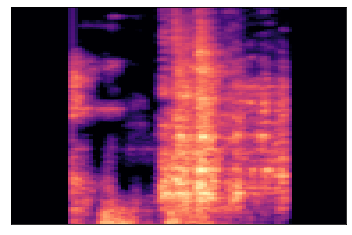

In [87]:
my_dpi = 96 # dpi of the monitor
plt.figure(figsize=(128/my_dpi, 94/my_dpi))
fig, ax = plt.subplots()
librosa.display.specshow(S_dB, sr=sr, ax=ax)

In [123]:
fig, ax = plt.subplots()
plt.tight_layout()
librosa.display.specshow(S_dB, sr=sr, ax=ax)
plt.savefig(f'prova1.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

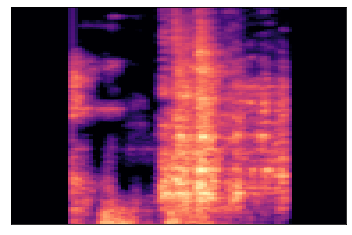

In [124]:
librosa.display.specshow(S_dB, sr=sr)
plt.savefig(f'prova2.png')

In [53]:
np.shape(S_dB)

(128, 94)

In [41]:
S_dB

array([[-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       ...,
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.]])

In [102]:
type(S_dB)

numpy.ndarray

In [ ]:
for count, sample in enumerate(processed_samples):
    

label = 'Bleatings ContactCalls Others'.split()
for g in genres:
    pathlib.Path(f'img/{g}').mkdir(parents=True, exist_ok=True)
    for sample in processed_samples:
        
        plt.axis('off');
        
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

# Features MFCC and Delta-MFCC

Let's extract as presented in analysis.ipybn the MFCC and delta-MFCC realted features

In [65]:
features = []
for sample in tqdm_notebook(processed_samples):
    mfccs = librosa.feature.mfcc(sample, sr = sr, n_mfcc=20)
    mfccs_trunc = np.hstack((np.mean(mfccs, axis=1), np.std(mfccs, axis=1), np.max(mfccs, axis = 1),
                             np.median(mfccs, axis = 1), np.min(mfccs, axis = 1)))
    mfccs_delta = librosa.feature.delta(mfccs, mode='nearest')
    mfccs_delta_trunc = np.hstack((np.mean(mfccs_delta, axis=1), np.std(mfccs_delta, axis=1), np.max(mfccs_delta, axis = 1),
                                   np.median(mfccs_delta, axis = 1), np.min(mfccs_delta, axis = 1)))
    features.append(np.concatenate((mfccs_trunc, mfccs_delta_trunc)))

np.shape(features)

  0%|          | 0/827 [00:00<?, ?it/s]

C:\Users\Nicolas Facchinetti\.conda\envs\progapr\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1536
  warnings.warn(
C:\Users\Nicolas Facchinetti\.conda\envs\progapr\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1856
  warnings.warn(


Then we can standardize the values obtained to have all the values on the same scale

In [85]:
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

array([[ 0.34781968,  0.15523269, -0.23216898, ..., -0.480913  ,
         0.11557389, -0.8617569 ],
       [ 0.60053222, -0.00914684, -0.80729602, ...,  0.87441772,
         0.92124129,  0.42715648],
       [ 0.14690949,  0.49406041, -0.09727726, ..., -0.437311  ,
         0.15639632, -0.1634006 ],
       ...,
       [-0.80134407,  0.67376678,  1.64300066, ...,  0.4749902 ,
         0.44821466,  0.12015271],
       [-1.06595033,  0.50232601,  1.30117149, ..., -0.23080317,
        -0.31921245, -1.05481112],
       [-1.28945793, -0.10242232,  1.45239209, ...,  0.51314051,
        -1.91284518, -0.04138619]])

Finally we can squash all toghether the sample name, label and the extracted features. Save the obtained result to a .cvs file for processing with the models.

In [86]:
features_df1 = pd.concat([metadata[["path", "label"]], pd.DataFrame(scaled)], axis=1)
features_df1 = features_df1.set_index("path")

features_df1.to_csv("mfcc_deltamfcc.csv")
features_df1.head()

,label,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
path,,,,,,,,,,,,,,,,,,,,,
./Labelled/Bleatings/evt_000_000_000681_210415_150602.wav,Bleatings,0.347820,0.155233,-0.232169,-0.201178,0.206299,-0.812587,0.350786,-0.459605,-0.483644,...,-0.136273,-1.512237,0.313718,-0.025292,0.424550,0.618080,0.493849,-0.480913,0.115574,-0.861757
./Labelled/Bleatings/evt_000_000_000682_210415_150623.wav,Bleatings,0.600532,-0.009147,-0.807296,-0.633419,-0.555820,-0.483127,-0.247325,0.688479,1.102261,...,0.158165,-0.020859,0.099358,0.669381,-0.757209,0.146002,0.395391,0.874418,0.921241,0.427156
./Labelled/Bleatings/evt_000_000_000683_210415_150637.wav,Bleatings,0.146909,0.494060,-0.097277,0.017268,0.327210,0.516250,0.927306,-1.170098,0.393075,...,-0.856356,-0.551477,-0.552312,0.002518,-0.085520,-0.047403,-0.229064,-0.437311,0.156396,-0.163401
./Labelled/Bleatings/evt_000_000_000684_210415_150654.wav,Bleatings,0.805780,0.976582,-0.477301,0.686392,-0.606207,-1.136907,-1.306880,-0.922357,-0.334283,...,0.008805,-1.164836,-0.138124,0.264209,-0.138784,0.276497,-0.528750,0.180946,0.164339,-0.217783
./Labelled/Bleatings/evt_000_000_002434_210416_073853.wav,Bleatings,0.651157,-0.002178,-0.902648,0.265438,-1.208112,-0.640320,-0.343720,1.102376,0.713345,...,0.756449,0.452530,0.357011,0.359743,0.118464,0.318001,0.526162,0.199136,-0.190216,-0.760688


# Extract example features set

In [5]:
# shuffle the data
to_load = to_load.sample(frac=1)

In [11]:
features = []
for element in tqdm_notebook(to_load.values.tolist()[:50]):
    features_vector = []
    filename = element[0]
    y, sr = librosa.load(filename)
    
    # add filename for later indexing the dataframe
    features_vector.append(filename)
    
    rms = librosa.feature.rms(y=y)
    features_vector.append(np.mean(rms))
    #chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    #spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    #rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    features_vector.append(np.mean(zcr))
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    features_vector = features_vector + [np.mean(e) for e in mfccs]
    
    #to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    #for e in mfcc:
    #    to_append += f' {np.mean(e)}'
    
    # add the label
    features_vector.append(element[1])
    features.append(features_vector)

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
features_df = pd.DataFrame(features, columns=["filename", "rms", "zcr"] + [f'mfcc{i}' for i in range(20)]+ ["label"])
features_df = features_df.set_index("filename")
features_df.head()

,rms,zcr,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,label
filename,,,,,,,,,,,,,,,,,,,,,
./Labelled/Bleatings/evt_000_003_017370_210422_143739.wav,0.016555,0.098719,-333.899994,142.983856,-56.197685,41.681320,-15.505000,9.609718,7.344662,10.028235,...,5.601384,4.752415,-4.012461,3.964277,-0.381156,10.751761,8.088605,4.815539,-0.730275,Bleatings
./Labelled/Others/evt_000_001_050725_210507_041404.wav,0.006705,0.064619,-410.253906,160.915268,-40.434196,52.212326,-19.761183,26.582207,-6.959056,13.494112,...,-0.789553,5.086392,-5.798947,7.198698,-9.410315,6.736906,-3.345610,4.026073,-0.839583,Others
./Labelled/Others/evt_000_004_056196_210512_095729.wav,0.022746,0.076490,-305.385803,136.546478,-26.544491,24.138884,2.732224,4.278108,3.278859,2.297472,...,-2.268005,1.848497,-1.533101,0.513620,-0.386419,4.270723,0.889709,2.118828,3.440112,Others
./Labelled/Others/evt_000_003_069975_210516_172141.wav,0.012991,0.092632,-322.414490,164.939301,-68.396179,43.906757,-21.451475,26.462368,-17.275246,16.139709,...,-3.744617,9.959677,-7.539350,6.872898,-4.783088,8.239529,-5.825597,2.630365,0.786140,Others
./Labelled/Others/evt_001_003_028392_210429_190724.wav,0.007446,0.089268,-362.616333,142.717361,-47.316021,55.047962,-21.027283,26.120560,-12.984117,9.336222,...,-3.544557,7.074082,-6.766791,11.192875,-7.160723,6.033654,-2.298451,3.237531,-0.823168,Others


In [13]:
features_df.to_csv("sample.csv")